#### check data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "../data/eleme.xlsx"
df = pd.read_excel(
    path,
    sheet_name=0
)

/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
df.shape

(707, 10)

In [4]:
df.head()

,下单时间,订单号,商户信息,商品及数量,商品描述,收货人,地址,订单金额(元),订单状态,订单子类型
0,2025-11-02 19:21:27,8067986093855079925,上海本帮现炒浇头面,"1、商品:纯肉烤肠, 数量:1;\n2、商品:###不需要餐具, 数量:1;\n3、商品:葱...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,20.78元,已完成,NaN
1,2025-10-31 19:12:33,8067986092873502180,遇见小面(辉煌国际店),"1、商品:销魂擂椒卤肉饭, 数量:1;\n2、商品:无需餐具包, 数量:1;\n3、商品:秘...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,27.6元,已完成,NaN
2,2025-10-30 16:40:45,8067986092361811213,老广烧腊(盈创店),"1、商品:猪脚任性双拼饭, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,24.8元,已完成,NaN
3,2025-10-30 16:37:57,8067986092370346321,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21.3元,已完成,NaN
4,2025-10-29 16:05:15,8067986091942476182,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21元,已完成,NaN


### minimal version of DS agent
1. data loader func
2. eda_agent (code-as-action with reflection)
3. exec_sandbox (controlled exec)

User Query → Code Generator → Executor (V1) → Reflector → Code Generator → Executor (V2) → Results

In [ ]:
# Standard library
import re
import io
import sys
import traceback
from pathlib import Path
from typing import Dict, Any, Optional, Union
import json

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from IPython.display import display, Image, HTML
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()

In [ ]:
# Configure matplotlib for Chinese text rendering
import platform

# Detect OS and set appropriate Chinese fonts
os_name = platform.system()

if os_name == "Darwin":  # macOS
    chinese_fonts = ['PingFang SC', 'STHeiti', 'Arial Unicode MS']
elif os_name == "Windows":
    chinese_fonts = ['Microsoft YaHei', 'SimHei', 'KaiTi']
else:  # Linux
    chinese_fonts = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'Droid Sans Fallback']

# Set font family with Chinese fonts first, then fallback to sans-serif
plt.rcParams['font.sans-serif'] = chinese_fonts + plt.rcParams['font.sans-serif']

# Fix minus sign display issue (common with Chinese fonts)
plt.rcParams['axes.unicode_minus'] = False


In [266]:
def print_generated_code(output: Union[str, Dict[str, Any]], show_tags: bool = False) -> None:
    """
    Pretty-print output from generate_eda_code or execute_code.
    
    Args:
        output: Either:
            - String from generate_eda_code (code with/without tags)
            - Dict from execute_code (execution results)
        show_tags: Whether to show XML tags (only for string input)
    """
    # Handle dict output (from execute_code)
    if isinstance(output, dict):
        print("=" * 70)
        print("full output")
        print("=" * 70)
        
        # Print code
        if "code" in output:
            print("\n📝 CODE:")
            print("-" * 70)
            print(output["code"])
        
        # Print stdout
        if output.get("stdout"):
            print("\n📤 OUTPUT:")
            print("-" * 70)
            print(output["stdout"])
        
        # Print result
        if output.get("result") is not None:
            print("\n✅ RESULT:")
            print("-" * 70)
            import json
            if isinstance(output["result"], (dict, list)):
                import pprint
                pprint.pprint(output["result"], width=100, sort_dicts=False)
            else:
                print(output["result"])
        
        # Print error
        if output.get("error"):
            print("\n❌ ERROR:")
            print("-" * 70)
            print(output["error"])
        
        # Print image path
        if output.get("image_path"):
            print(f"\n📈 VISUALIZATION: {output['image_path']}")
            display(Image(filename=output["image_path"]))
        
        return
    
    # Handle string output (from generate_eda_code)
    if isinstance(output, str):
        # Extract code from tags if present
        match = re.search(r"<execute_python>(.*?)</execute_python>", output, re.DOTALL | re.IGNORECASE)
        
        if match:
            code = match.group(1).strip()
            
            if show_tags:
                print("=" * 70)
                print("FULL OUTPUT (with tags)")
                print("=" * 70)
                print(output)
                print("\n")
            
            print("=" * 70)
            print("GENERATED CODE")
            print("=" * 70)
            print(code)
        else:
            # No tags found, just print as-is
            print("=" * 70)
            print("OUTPUT")
            print("=" * 70)
            print(output)



In [348]:


def load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from CSV or Excel file.
    
    Args:
        file_path: Path to the data file
        
    Returns:
        pandas DataFrame
        
    Raises:
        ValueError: If file format is not supported or file doesn't exist
    """
    path = Path(file_path)
    
    if not path.exists():
        raise ValueError(f"File not found: {file_path}")
    
    # Determine loader based on file extension
    if path.suffix.lower() == '.csv':
        df = pd.read_csv(file_path)
    elif path.suffix.lower() in ['.xlsx', '.xls']:
        df = pd.read_excel(file_path)
    else:
        raise ValueError(f"Unsupported file format: {path.suffix}. Use .csv, .xlsx, or .xls")
    
    # Basic validation
    if df.empty:
        raise ValueError("Loaded DataFrame is empty")
    
    print(f"✓ Loaded data: {df.shape[0]} rows × {df.shape[1]} columns")
    return df

In [349]:
def get_response(
    system_prompt: str,
    user_prompt: str,
    model: str = "gpt-5-mini", #"gpt-5-mini",
    reasoning_effort: str = "minimal",
    verbosity: str = "low",
    image_path: Optional[str] = None,
    response_format: Optional[dict] = None
) -> str:
    """
    Get response from OpenAI GPT-5 series models, multimodal input.
    
    Args:
        system_prompt: System instructions
        user_prompt: User query
        model: GPT-5 model to use
        reasoning_effort: "minimal", "low", "medium", "high"
        verbosity: 'low', 'medium', or 'high'
        image_path: optional image path
    Returns:
        Model response content
    """
    messages = [{"role": "system", "content": system_prompt}]
    
    if image_path:
        import base64
        with open(image_path, "rb") as f:
            image_data = base64.b64encode(f.read()).decode()
        
        messages.append({
            "role": "user",
            "content": [
                {"type": "text", "text": user_prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_data}"}}
            ]
        })
    else:
        messages.append({"role": "user", "content": user_prompt})

    response = client.chat.completions.create(
        model=model,
        reasoning_effort=reasoning_effort,
        verbosity=verbosity,
        messages=messages,
        response_format=response_format,
    )
    
    return response.choices[0].message.content

In [350]:
# rules for coding behaviors

EDA_CODE_RULE = """
- ONLY use one or more packages in the allowed_package_list; DO NOT use or import packages that not on the list.
   - allowed_package_list: pandas, matplotlib, re.
- Assume the DataFrame is already loaded as 'df' and it's not empty, no need to check.
- Write clear, step-by-step code with necessary comments. Do not add explanations.
- Handle edge cases (empty results, missing values, etc.).
- Store final answer/insight in a variable called 'result' (string or dict).
- DO NOT print any results.
- For visualizations, if requested:
   - Create at most ONE clear, labeled plot.
   - Use plt.title(), plt.xlabel(), plt.ylabel().
   - Don't call plt.show(), plt.savefig() or plt.close().

"""

# Define safe globals (read-only access to libraries)
SAFE_GLOBALS = {
   "pd": pd,
   "plt": plt,
   "re": re,
   # "np": np,
   # "display": display,
   # "Image": Image,
   # "HTML": HTML,
}
    

In [351]:
def generate_eda_code(
    query: str,
    df: pd.DataFrame,
    include_viz: bool = True
) -> str:
    """
    Generate Python code for EDA task, with one viz maximal, using pd, plt only.
    
    Args:
        query: User's analysis request
        df: DataFrame to analyze (used for schema info)
        include_viz: Whether to include visualization in the code
        
    Returns:
        Generated Python code wrapped in <execute_python> tags
    """
    # Build schema information
    schema_info = []
    schema_info.append(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    schema_info.append(f"\nColumns:")
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        schema_info.append(f"  - {col}: {dtype} (nulls: {null_count}, {null_pct:.1f}%)")
    
    schema_info.append(f"\nFirst 3 rows:")
    schema_info.append(df.head(3).to_string())
    
    schema_text = "\n".join(schema_info)
    
    # Build prompt
    system_prompt = f"""You are a senior data analyst. Write clean python code for exploratory data analysis.
Keep it concise, focus on the specific request.
Return your answer *strictly* in this format:
<execute_python>
# valid python code here
</execute_python>

Requirements for the code:
{EDA_CODE_RULE}
"""
    
    viz_instruction = " Include ONE appropriate plot." if include_viz else ""
    
    user_prompt = f"""Dataset Schema:
{schema_text}

User Request:
{query}{viz_instruction}

Generate Python code to analyze this request."""
    
    # Call LLM
    response = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt
    )
    
    return response


In [365]:
def execute_code(
    code: str,
    df: pd.DataFrame,
    output_image_path: Optional[str] = None
) -> Dict[str, Any]:
    """
    Execute generated Python code in a controlled namespace.
    
    Args:
        code: Python code to execute (with or without <execute_python> tags)
        df: DataFrame to analyze
        output_image_path: Path to save matplotlib figures (optional)
        
    Returns:
        Dictionary containing:
            - code: Extracted Python code
            - stdout: Captured print statements
            - error: Error traceback (None if successful)
            - result: Value of 'result' variable if set by code
            - image_path: Path to saved image (if any)
    """
    # Extract code from tags if present
    match = re.search(r"<execute_python>(.*?)</execute_python>", code, re.DOTALL | re.IGNORECASE)
    code = match.group(1).strip() if match else code.strip()
    
    # Define safe locals (includes the DataFrame)
    namespace = {**SAFE_GLOBALS, "df": df.copy()}
    
    # Capture stdout
    stdout_buffer = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = stdout_buffer
    
    error = None
    try:
        exec(code, namespace)
        
        # Save any matplotlib figures
        if output_image_path and plt.get_fignums():
            plt.savefig(output_image_path, bbox_inches='tight', dpi=150)
            plt.close('all')  # Clean up
            
    except Exception:
        error = traceback.format_exc()
    finally:
        sys.stdout = old_stdout
    
    return {
        "code": code,
        "stdout": stdout_buffer.getvalue().strip(),
        "error": error,
        "result": namespace.get("result"),
        "image_path": output_image_path if output_image_path and Path(output_image_path).exists() else None,
    }

In [353]:
def reflect_and_improve(
    query: str,
    df: pd.DataFrame,
    v1_code: str,
    v1_result: Dict[str, Any]
) -> str:
    """
    Reflect on V1 results and generate improved code.
    
    Args:
        query: Original user request
        df: DataFrame being analyzed
        v1_code: Code from V1
        v1_result: Execution results from V1
        
    Returns:
        feedback and improved Python code wrapped in <execute_python> tags
    """
    # Build feedback string
    feedback_parts = []
    image_path = None
    if v1_result["error"]:
        feedback_parts.append(f"ERROR:\n{v1_result['error']}")
    
    if v1_result["stdout"]:
        feedback_parts.append(f"Output:\n{v1_result['stdout']}")
    
    if v1_result["result"]:
        feedback_parts.append(f"Result variable:\n{v1_result['result']}")
    
    if v1_result["image_path"]:
        feedback_parts.append(f"Visualization provided")
        image_path = v1_result["image_path"]

    feedback = "\n\n".join(feedback_parts)
    
    # Build reflection prompt
    system_prompt = f"""You are a senior code reviewer. 

Your task:
- First, critique how well the V1 code and results answer the original request; identify issues (errors, poor analysis choices, unclear visualizations).
- Then generate V2 code that fixes these issues; keep the same output format and variable names.

STRICT OUTPUT FORMAT (JSON only):
{{
 "feedback": "<brief, specific critique and suggestions>",
 "v2_code": "<ONLY python code, wrapped in <execute_python> tags>"
}}

Requirements for the code:
{EDA_CODE_RULE}
"""
    
    user_prompt = f"""Original Request:
{query}

V1 Code:
{v1_code}

V1 Execution Results:
{feedback}

Generate feedback and improved V2 code that addresses any issues and provides better analysis/visualization."""
    
    # print(system_prompt)
    # print(user_prompt)
    # print(image_path)
    
    response = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        image_path=image_path,
        response_format={"type": "json_object"}
    )
    
    # Robust JSON parse
    try:
        obj = json.loads(response)
    except Exception:
        m = re.search(r"\{.*\}", response, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"feedback": response, "v2_code": ""}

    feedback = str(obj.get("feedback", "")).strip()
    v2_code = str(obj.get("v2_code", "")).strip()

    return feedback, v2_code




In [354]:
def present_result(
    final_result: Dict[str, Any],
    query: str,
) -> str:
    """
    Present the final_result using LLM to generate a natural language summary.
    
    Args:
        final_result: Dictionary containing execution results (from eda_agent)
        query: Original user query
        
    Returns:
        Natural language presentation of the results
    """
    # Prepare the result data for the LLM
    result_data_parts = []
    
    # Include the result variable if present
    if final_result.get("result"):
        result_data_parts.append(str(final_result['result']))

    
    result_data = "\n\n".join(result_data_parts)
    
    # Build prompt for presentation
    system_prompt = """You are a data analyst presenting EDA findings to answer the specific user question.
Your task is to:
1. Summarize the analysis in clear natural language.
2. Highlight key insights and interesting findings.
3. Explain any visualizations that were created.
4. DO NOT assume any information about the user.

"""

    viz_instruction = "Visualizations provided." if final_result.get("image_path") else ""

    user_prompt = f"""User Question:
{query}

Analysis Results:
{result_data}
{viz_instruction}

Please provide a clear, natural language summary of these findings."""
    
    # Get LLM presentation
    presentation = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        image_path=final_result.get("image_path")
    )
    
    return presentation

    # print(system_prompt)
    # print(user_prompt)


In [361]:
def eda_agent(
    query: str,
    df: pd.DataFrame,
    use_reflection: bool = True,
    include_viz: bool = True,
    output_dir: str = "./output"
) -> Dict[str, Any]:
    """
    Main EDA agent that orchestrates the full workflow.
    
    Args:
        query: User's analysis request
        df: DataFrame to analyze
        use_reflection: Whether to use reflection pattern (V1 → V2)
        include_viz: Whether to include visualizations
        output_dir: Directory to save output images
        
    Returns:
        Dictionary containing:
            - query: Original request
            - v1: V1 execution results
            - v2: V2 execution results (if reflection enabled)
            - final_result: Best result (V2 if available, else V1)
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print(f"📊 EDA Agent Processing: {query}\n")
    
    # ===== V1: Initial code generation and execution =====
    print("🔄 Generating V1 code...")
    v1_code = generate_eda_code(
        query=query,
        df=df,
        include_viz=include_viz
    )
    
    # print('v1_code:')
    # print(v1_code)
    print("⚙️  Executing V1 code...")
    
    v1_image_path = str(output_path / "v1_plot.png") if include_viz else None
    v1_result = execute_code(v1_code, df, v1_image_path)
    
    if v1_result["error"]:
        print(f"❌ V1 Error:\n{v1_result['error']}")
    else:
        print("✅ V1 execution successful")
    
    # ===== V2: Reflection and improved code =====
    v2_result = None
    if use_reflection:
        print("\n🤔 Reflecting on V1 results...")
        feedback, v2_code = reflect_and_improve(
            query=query,
            df=df,
            v1_code=v1_result["code"],
            v1_result=v1_result
        )
        # print('feedback:')
        # print(feedback)
        # print('v2_code:')
        # print(v2_code)
        print("⚙️  Executing V2 code...")
        v2_image_path = str(output_path / "v2_plot.png") if include_viz else None
        v2_result = execute_code(v2_code, df, v2_image_path)
        
        if v2_result["error"]:
            print(f"❌ V2 Error:\n{v2_result['error']}")
            print("⚠️  Using V1 results as fallback")
        else:
            print("✅ V2 execution successful")
    
    # ===== Select best result =====
    final_result = v2_result if (v2_result and not v2_result["error"]) else v1_result
    
    print("Preparing final report")

    # ===== present result =====
    print("\n" + "="*60)
    print("📊 FINAL RESULT")
    print("="*60)
    
    result_summary = present_result(final_result, query)
    print(result_summary)
    if ["image_path"]:
        print(f"\n📈 Visualization: {final_result['image_path']}")
        display(Image(filename=final_result["image_path"]))
    
    

    return {
        "query": query,
        "v1_code": v1_code,
        "v1_result": v1_result,
        "feedback": feedback,
        "v2_code": v2_code,
        "v2_result": v2_result,
        "final_result": final_result,
        "result_summary": result_summary
    }

📊 EDA Agent Processing: tell me about the data.

🔄 Generating V1 code...
v1_code:
<execute_python>
# EDA for provided DataFrame 'df'
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Basic info
info = {
    "shape": df.shape,
    "columns": list(df.columns),
    "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict(),
    "null_counts": df.isnull().sum().to_dict()
}

# 2. Clean and standardize '订单金额(元)' to numeric (handle trailing '元' and non-numeric)
def parse_amount(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    s = re.sub(r"[^\d\.\-]", "", s)  # keep digits, dot, minus
    try:
        return float(s) if s != "" else None
    except:
        return None

df["_amount_num"] = df["订单金额(元)"].apply(parse_amount)

# 3. Summary statistics for amount with handling missing
amount_stats = {}
amt = df["_amount_num"].dropna()
if len(amt) > 0:
    amount_stats = {
        "count": int(amt.count()),
        "mean": float(amt.mean()),
        "median": float(

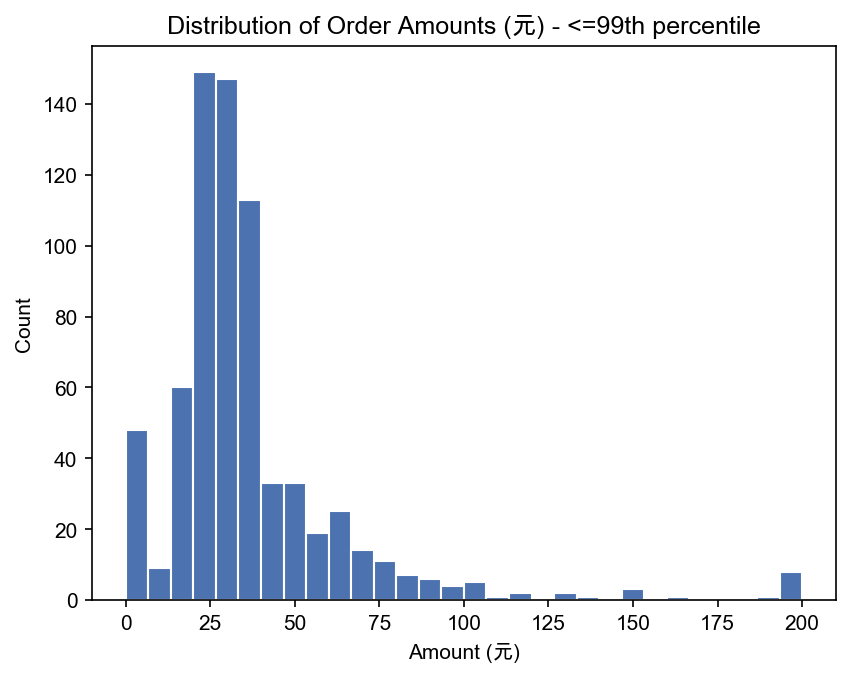

In [357]:
result1 = eda_agent(
    query="tell me about the data.",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: tell me about the data and find something interesting

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Summary of the data
- Dataset: 707 orders, 10 columns (order time, order ID, merchant, items/quantities, product description, recipient, address, order amount, order status, order subtype).
- Revenue: total ≈ 27,180.85 yuan; average order value ≈ 38.45 yuan; median order value = 30.00 yuan.
- Order status: most orders completed — 677 completed, 24 closed, 6 refunded.

Key data quality notes
- Very high missingness for two fields: product description and order subtype are missing for 99.72% of rows (705 of 707). These fields are effectively empty and limit product-level or subtype analyses.
- Some missing recipients (18) and addresses (33).
- Order amount currently stored as object (string); convert to numeric for ro

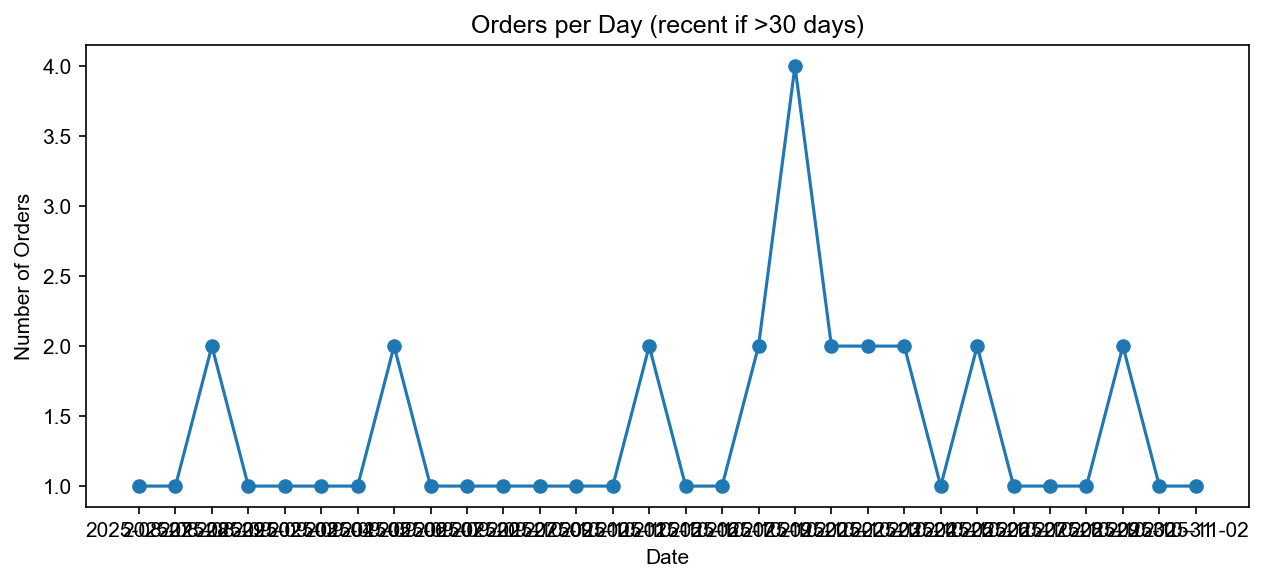

In [367]:
result2 = eda_agent(
    query="tell me about the data and find something interesting",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

In [364]:
print(result2['v2_code'])

<execute_python>
import pandas as pd
import matplotlib.pyplot as plt
import re

# Step 0: required column names (adjust if different)
expected_cols = ["下单时间", "订单号", "商户信息", "商品及数量", "商品描述", "收货人", "地址", "订单金额(元)", "订单状态", "订单子类型"]
# If some expected columns are missing, create them as empty to avoid KeyError
for c in expected_cols:
    if c not in df.columns:
        df[c] = pd.NA

# 1) Basic overview (concise)
overview = {
    "rows": int(df.shape[0]),
    "columns": int(df.shape[1]),
    "non_null_counts": df.notnull().sum().to_dict(),
}

# 2) Robust amount parsing: remove currency characters, handle parentheses (negative), commas
def parse_amount(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    # handle values in parentheses as negative, e.g. (123.45)
    negative = False
    if s.startswith("(") and s.endswith(")"):
        negative = True
        s = s[1:-1]
    # remove common currency symbols/words
    s = re.sub(r"[￥¥$元]|CNY|RMB", "", s, flags=re.IGNORECAS

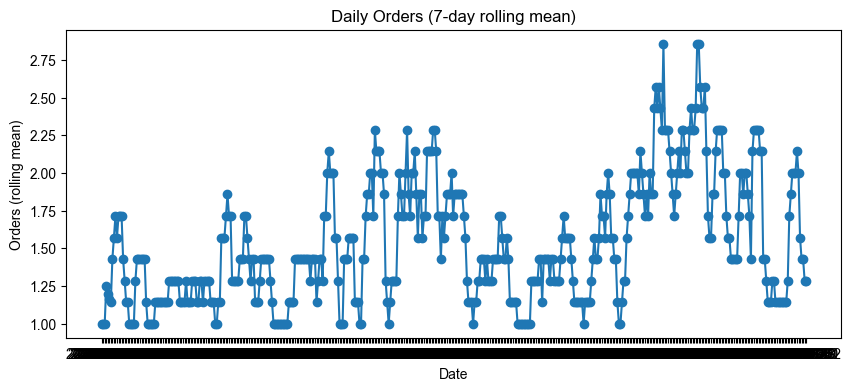

In [366]:
v2_result = execute_code(result2['v2_code'], df)

In [ ]:
## todo, solve unclear axis

In [289]:
df_eleme = load_data("../data/eleme.xlsx")

✓ Loaded data: 707 rows × 10 columns


/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [290]:
df_eleme.head()

,下单时间,订单号,商户信息,商品及数量,商品描述,收货人,地址,订单金额(元),订单状态,订单子类型
0,2025-11-02 19:21:27,8067986093855079925,上海本帮现炒浇头面,"1、商品:纯肉烤肠, 数量:1;\n2、商品:###不需要餐具, 数量:1;\n3、商品:葱...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,20.78元,已完成,NaN
1,2025-10-31 19:12:33,8067986092873502180,遇见小面(辉煌国际店),"1、商品:销魂擂椒卤肉饭, 数量:1;\n2、商品:无需餐具包, 数量:1;\n3、商品:秘...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,27.6元,已完成,NaN
2,2025-10-30 16:40:45,8067986092361811213,老广烧腊(盈创店),"1、商品:猪脚任性双拼饭, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,24.8元,已完成,NaN
3,2025-10-30 16:37:57,8067986092370346321,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21.3元,已完成,NaN
4,2025-10-29 16:05:15,8067986091942476182,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21元,已完成,NaN


📊 EDA Agent Processing: tell me about the data.

🔄 Generating V1 code...
v1_code:
<execute_python>
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assumes df is already loaded in the environment
# 1) Basic schema and data info
# Compute basic info: shape, dtypes, missing values per column
shape = df.shape
dtypes = df.dtypes.to_dict()
missing_counts = df.isnull().sum().to_dict()
missing_pct = (df.isnull().mean() * 100).round(2).to_dict()

# 2) Basic statistics about numeric-like columns
# Try to convert "订单金额(元)" to numeric if possible
money_col = "订单金额(元)"
if money_col in df.columns:
    # Remove currency symbol and parse numbers
    money_series = df[money_col].astype(str).str.replace('[^0-9.]', '', regex=True)
    df_money = pd.to_numeric(money_series, errors='coerce')
else:
    df_money = pd.Series(dtype=float)

average_order_value = df_money.mean() if not df_money.empty else None
median_order_value = df_money.median() if not df_money.empty else None
tota

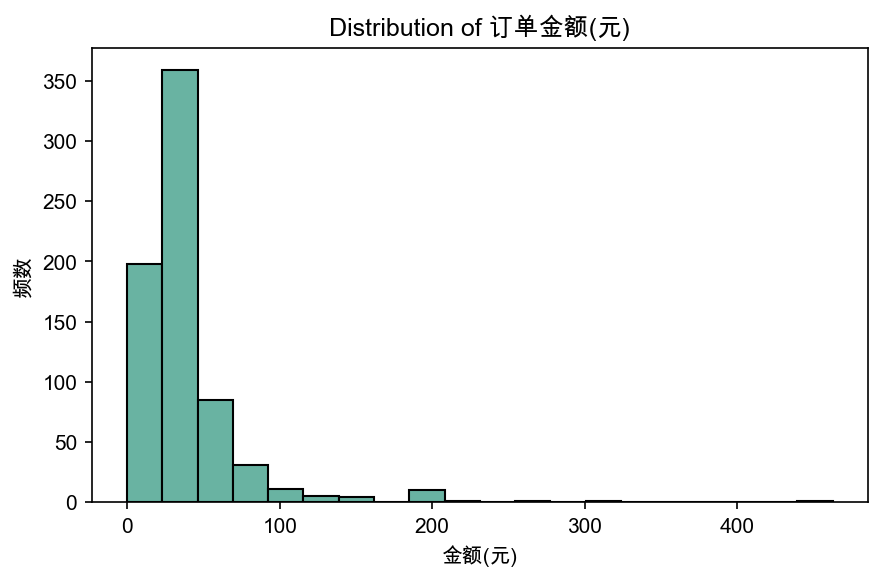

In [ ]:
result1 = eda_agent(
    query="tell me about the data.",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: tell me about the data and what are the interesting findings.

🔄 Generating V1 code...
v1_code:
<execute_python>
# Import allowed packages
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is already loaded and non-empty

# Basic info
# Handle potential non-numeric amount column by cleaning
# 1) Clean '订单金额(元)' to numeric, extract numeric value from strings like "20.78元"
def to_numeric_amount(s):
    if pd.isna(s):
        return pd.NA
    # remove currency symbol and any trailing text
    s = str(s).strip()
    # extract number using regex
    import re
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)", s)
    if m:
        try:
            return float(m.group(1))
        except:
            return pd.NA
    return pd.NA

# Apply cleaning
df_clean = df.copy()
df_clean['订单金额(元)'] = df_clean['订单金额(元)'].apply(to_numeric_amount)

# Handle missing values: report counts
missing_counts = df_clean.isna().sum()

# Derive simple insights
# 1. Distribution of ord

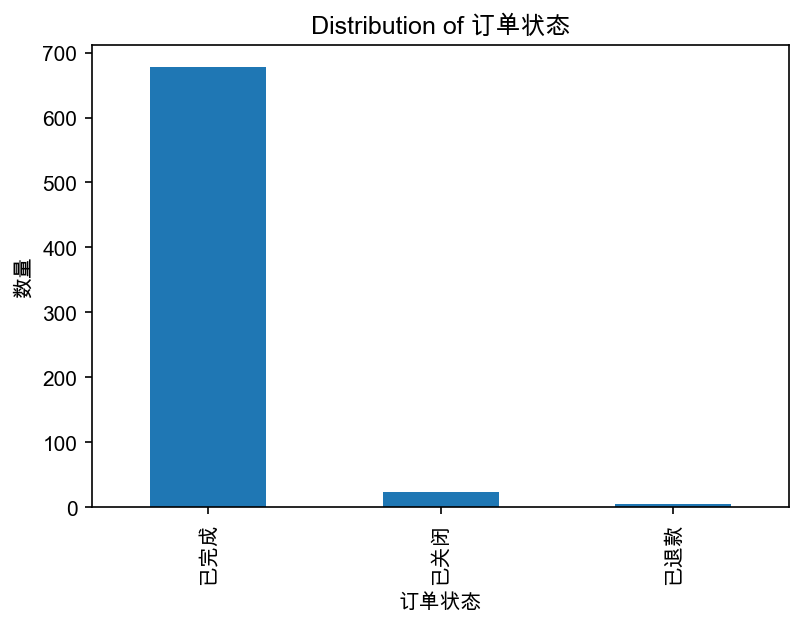

In [309]:
result1 = eda_agent(
    query="tell me about the data and what are the interesting findings.",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: tell me about the data and what are the interesting findings.

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful

📊 FINAL RESULT

{'data_shape': (707, 10), 'data_types': {'下单时间': dtype('O'), '订单号': dtype('int64'), '商户信息': dtype('O'), '商品及数量': dtype('O'), '商品描述': dtype('O'), '收货人': dtype('O'), '地址': dtype('O'), '订单金额(元)': dtype('O'), '订单状态': dtype('O'), '订单子类型': dtype('O')}, 'missing_values': {'下单时间': 0, '订单号': 0, '商户信息': 0, '商品及数量': 0, '商品描述': 705, '收货人': 18, '地址': 33, '订单金额(元)': 0, '订单状态': 0, '订单子类型': 705}, 'order_amount_distribution': {'count': 707.0, 'mean': 38.4453323903819, 'std': 36.942393931642975, 'min': 0.0, '25%': 22.0, '50%': 30.0, '75%': 41.45, 'max': 462.41}, 'most_common_order_status': '已完成', 'most_common_order_status_count': np.int64(677)}

📈 Visualization: output/v2_plot.png


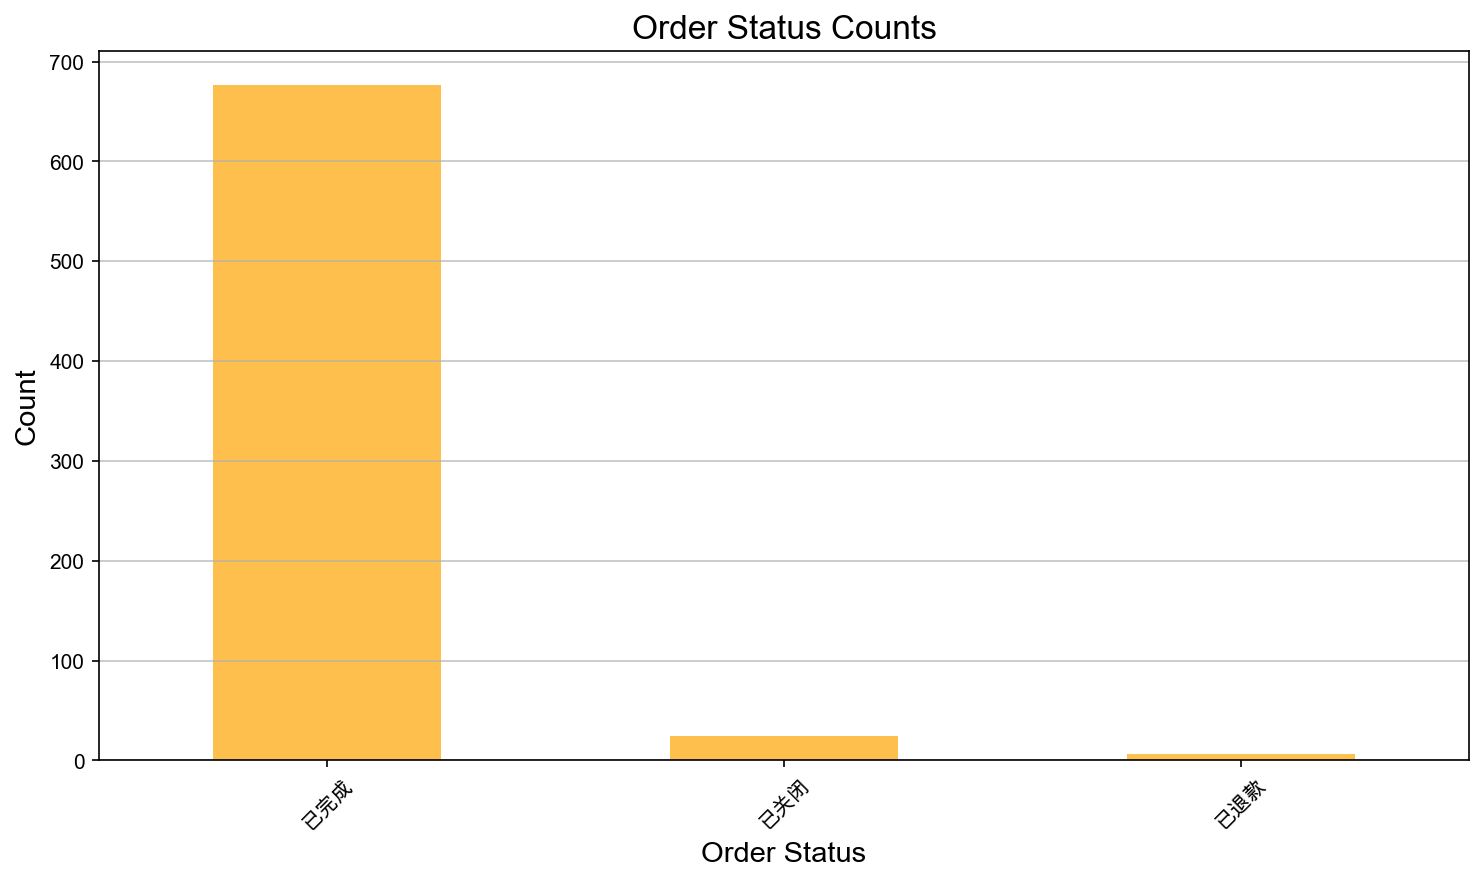

In [ ]:
result1 = eda_agent(
    query="tell me about the data and what are the interesting findings.",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)